# Intro

This dataset describes 5-star rating and free text tagging activity from Movielens. 
It contains 27,753,444 ratings across 58,098 movies. These data were created by 283,228 users between 1/9/95 to 9/26/18. This dataset was generated on 9/26/18.

Users were selected at random. All selected users had rated at least 1 movies. 

In [1]:
from datetime import datetime
from IPython.display import Markdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
movies = pd.read_csv('ml-latest/movies.csv', sep=',')
ratings = pd.read_csv('ml-latest/ratings.csv', sep=',')

In [3]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
movieId    58098 non-null int64
title      58098 non-null object
genres     58098 non-null object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [5]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


## Data cleaning:

We have 27 million ratings data for 58k movies, that is a lot of data. How clean is our dataset, will we end up using all the data? Here, I will focus on answering few key questions to filter our dataset to ensure the recommendation system I build is as accurate as possible. 

1. What is the number of unique users and movies
2. What is the distribution of rating
3. What is the number of rating each movie received
4. What is the number of ratings given by each user


**1. What is the number of unique users and movies?**

In [6]:
# Q1
num_users = ratings.userId.nunique()
num_movies = ratings.movieId.nunique()

print('There are {:,} unique users and {:,} unique movies in this dataset'.format(num_users, num_movies))

There are 283,228 unique users and 53,889 unique movies in this dataset


**2. Examine the rating distribution**

In [7]:
# count of each rating.
rating_count = pd.DataFrame(ratings.groupby('rating').size(), columns = ['count'])
rating_count

,count
rating,
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


Above table does not include counts of No rating. Let's check to see how many movies did not get a rating.

In [8]:
# total count = amount of all possible rating include no rating.
totalcount = num_users * num_movies
no_rating = totalcount - ratings.shape[0]

print("Amount of movies with no ratings: {:,}".format(no_rating))
print("Total possible rating: {:,}".format(totalcount))

Amount of movies with no ratings: 15,235,120,248
Total possible rating: 15,262,873,692


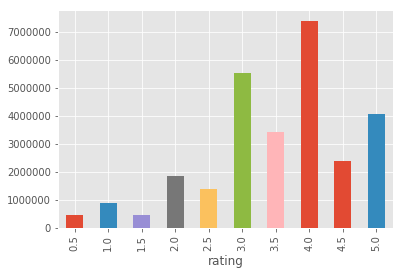

In [9]:
# Let's plot rating distribution

rating_count['count'].plot(kind='bar')

Most movies received a rating of 3 and 4, users seem to prefer to rate movies on whole number than half star scale.

**3. Plot rating frequency of all movies**

In [10]:
# Let's plot rating frequency of all movies.

movie_count = pd.DataFrame(ratings.groupby('movieId').size(), columns = ['count'])
movie_count.head()

,count
movieId,
1,68469
2,27143
3,15585
4,2989
5,15474


Text(0, 0.5, 'number of ratings')

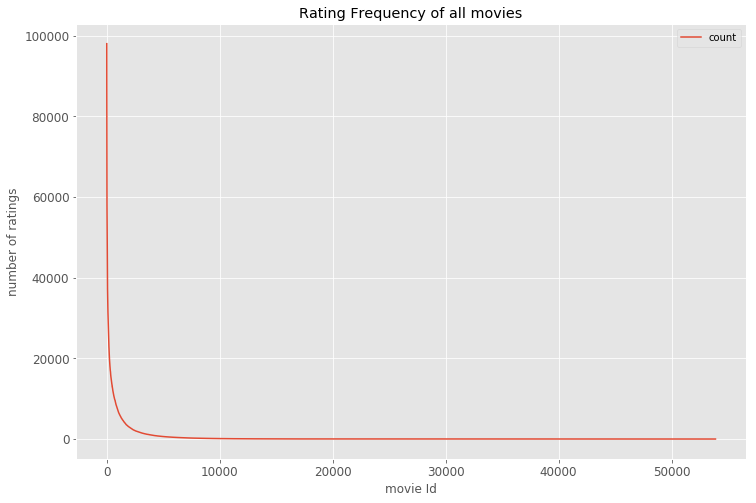

In [11]:
# plot rating frequency of all movies. 

ax = movie_count.sort_values('count', 
                   ascending=False).reset_index(drop=True).plot(
         figsize = (12, 8),
         title = 'Rating Frequency of all movies',
         fontsize = 12
     )
ax.set_xlabel('movie Id')
ax.set_ylabel('number of ratings')

Distribution of ratings among movies show that only small fraction of the items are rated frequently. These are the popular items. Vast majority of items are rarely rated. This result in a highly right skewed distribution of ratings.

**Let's plot the same distribution in log scale.**

Text(0, 0.5, 'number of ratings (log scale)')

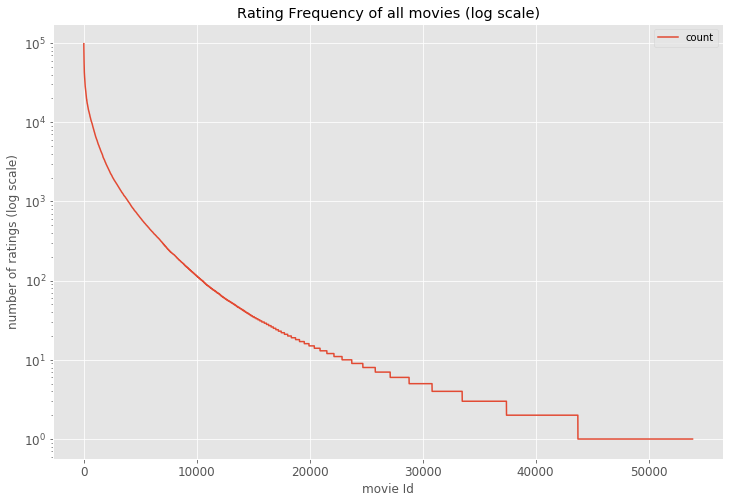

In [12]:
# plot rating frequency of all movies [log scale]

ax = movie_count.sort_values('count', 
                   ascending=False).reset_index(drop=True).plot(
         figsize = (12, 8),
         title = 'Rating Frequency of all movies (log scale)' ,
         fontsize = 12,
         logy = True
     )
ax.set_xlabel('movie Id')
ax.set_ylabel('number of ratings (log scale)')

10,000 out of 53,889 movies are rated more than 100 times, 20,000 out of 53,889 movies are rated a little more than 10 times, majority rest are much less known.

To remove noisy pattern, I will focus on ratings for only popular movies for now, movies that have high number of ratings.

Let's look at the quantile of the distribution.

In [13]:
movie_count['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    97999.0
0.95     1855.0
0.90      531.0
0.85      205.0
0.80       91.0
0.75       48.0
0.70       28.0
0.65       18.0
0.60       12.0
0.55        9.0
Name: count, dtype: float64

Highest rated movie has received 97,999 ratings, 5% of the movies have 1855+ ratings, 20% of the movies have 90+ ratings. 

For now, I will stick with movies that have more than 50 ratings, top 25% of the movies.

In [14]:
# filter data
threshold = 50
popular_movies = list(set(movie_count.query('count >= @threshold').index))

ratingfilter = ratings[ratings.movieId.isin(popular_movies)]
print("Shape of original rating data: ", ratings.shape)
print("Shape of rating data after dropping unpopular movies: ", ratingfilter.shape)

Shape of original rating data:  (27753444, 4)
Shape of rating data after dropping unpopular movies:  (27430748, 4)


After dropping unpopular movies in the dataset, we still have a large dataset, let's look at user data to further reduce size of the dataset.

**4. Number of ratings given by each user:**

In [15]:
# number of rating given by every user.

user_count = pd.DataFrame(ratingfilter.groupby('userId').size(), columns = ['count'])
user_count.head()

,count
userId,
1,16
2,15
3,11
4,736
5,72


Text(0, 0.5, 'number of ratings')

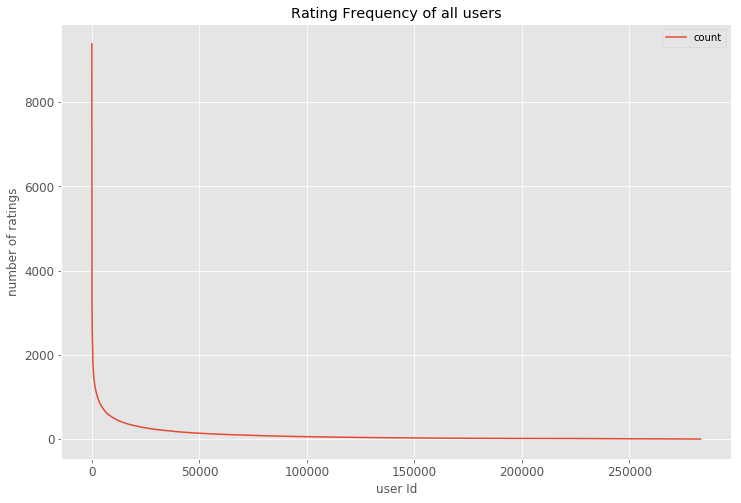

In [16]:
# plot rating frequency of all users.

ax = user_count.sort_values('count', 
                   ascending=False).reset_index(drop=True).plot(
         figsize = (12, 8),
         title = 'Rating Frequency of all users',
         fontsize = 12
     )
ax.set_xlabel('user Id')
ax.set_ylabel('number of ratings')

In [17]:
user_count['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    9384.0
0.95     403.0
0.90     239.0
0.85     164.0
0.80     121.0
0.75      94.0
0.70      73.0
0.65      58.0
0.60      47.0
0.55      37.0
Name: count, dtype: float64

Number of ratings given by each users is similar to number of ratings each movie received, both are heavily right skewed. 

The most active user has rated 9384 movies, 5% of users have rated 403+ movies, 20% of users have rated more than 120+ movies.

For now, I will stick with users that have rated more than 47 movies, top 40% of the users.

In [18]:
threshold = 47 
active_users = list(set(user_count.query('count >= @threshold').index))

ratingfilter = ratingfilter[ratingfilter.userId.isin(active_users)]
print("Shape of original rating data: ", ratings.shape)
print("Shape of rating data after dropping unpopular movies and inactive users: ", ratingfilter.shape)

Shape of original rating data:  (27753444, 4)
Shape of rating data after dropping unpopular movies and inactive users:  (24368204, 4)


In [19]:
num_users = ratingfilter.userId.nunique()
num_movies = ratingfilter.movieId.nunique()

print('There are {:,} unique users and {:,} unique movies in this dataset'.format(num_users, num_movies))

There are 113,427 unique users and 13,360 unique movies in this dataset


## Data storytelling:


After filtering popular movies and most active users, we are left with 113,427 unique users and 13,360 unique movies.


Let's now focus on **timestamp** variable, convert timestamp. I will sort the data by timestamp and break the timestamp column into year, month and day.

In [20]:
ratingfilter['timestamp'] = ratingfilter['timestamp'].apply(datetime.fromtimestamp)
ratingfilter['year'] = ratingfilter['timestamp'].dt.year
ratingfilter['month'] = ratingfilter['timestamp'].dt.month
ratingfilter['day'] = ratingfilter['timestamp'].dt.day

ratingfilter = ratingfilter.sort_values('timestamp')
ratingfilter.head(5)

,userId,movieId,rating,timestamp,year,month,day
5510411,56769,1176,4.0,1995-01-09 03:46:44,1995,1,9
23237833,237556,47,5.0,1995-01-09 03:46:49,1995,1,9
23237827,237556,21,3.0,1995-01-09 03:46:49,1995,1,9
23237876,237556,1079,3.0,1995-01-09 03:46:49,1995,1,9
2619749,26999,2,4.0,1996-01-28 16:00:00,1996,1,28


In [21]:
ratingfilter.tail(5)

,userId,movieId,rating,timestamp,year,month,day
27486420,280481,176101,3.5,2018-09-25 23:58:30,2018,9,25
27486116,280481,2294,2.0,2018-09-25 23:58:41,2018,9,25
27486118,280481,2355,3.0,2018-09-25 23:58:43,2018,9,25
27486035,280481,494,3.0,2018-09-25 23:58:47,2018,9,25
8060104,82922,53519,4.0,2018-09-25 23:58:50,2018,9,25


From our filtered rating dataset, the earliest movie was rated in January of 1995, and the most recent is rated September of 2018.

I would like to understand specifically at how rating distribution change over time by examining the following questions:

1. How does rating distribution change over time?
2. Does the rating distribution differ before and after half score are allowed?
3. How many ratings were submitted per year, month?
4. How consistent are the average ratings over time?

**1. How does rating distribution change over time**

In [22]:
ratings_pivot = pd.pivot_table(ratingfilter, values='timestamp', index='rating', columns='year', aggfunc='count')
ratings_pivot = ratings_pivot.apply(lambda x: x/np.sum(x), axis=0)
ratings_pivot = ratings_pivot.sort_index(ascending=False)
ratings_pivot

year,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
rating,,,,,,,,,,,,,,,,,,,,,
5.0,0.25,0.183318,0.206030,0.204745,0.236079,0.221129,0.204259,0.187617,0.121702,0.078603,...,0.095765,0.100780,0.103379,0.114445,0.122554,0.123520,0.134513,0.134815,0.134389,0.138496
4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086759,0.121926,...,0.129183,0.134507,0.136401,0.145671,0.146747,0.137459,0.113743,0.112729,0.116729,0.117359
4.0,0.25,0.289910,0.311941,0.334849,0.351171,0.348904,0.347126,0.345542,0.270497,0.234781,...,0.242897,0.245480,0.248332,0.253495,0.256819,0.252068,0.239241,0.234545,0.234340,0.231389
3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125078,0.191664,...,0.188927,0.188333,0.191220,0.182329,0.184469,0.180074,0.169661,0.169267,0.172421,0.170218
3.0,0.50,0.423626,0.380564,0.280501,0.253080,0.262842,0.274944,0.281202,0.199122,0.160044,...,0.154084,0.149738,0.148687,0.143143,0.141240,0.142902,0.154599,0.153681,0.152426,0.153194
2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052339,0.081776,...,0.074291,0.071810,0.070474,0.065906,0.059322,0.063138,0.065345,0.068639,0.068825,0.069264
2.0,NaN,0.063206,0.063788,0.116280,0.105219,0.109077,0.114566,0.125940,0.079438,0.059132,...,0.051830,0.049031,0.046746,0.044909,0.041321,0.045105,0.052595,0.052256,0.051208,0.051453
1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016075,0.026320,...,0.024196,0.021477,0.020307,0.017753,0.016543,0.017933,0.020775,0.021452,0.021741,0.021792
1.0,NaN,0.039940,0.037677,0.063624,0.054452,0.058048,0.059104,0.059698,0.035056,0.023451,...,0.019613,0.018675,0.017815,0.016485,0.016288,0.018275,0.023383,0.024494,0.024026,0.023133


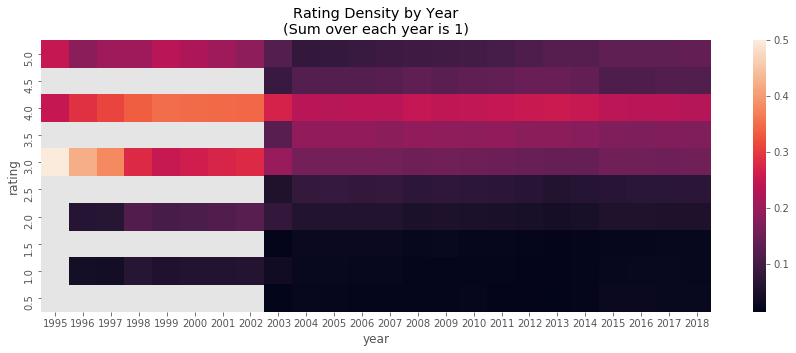

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(ratings_pivot, ax=ax)
ax.set_title('Rating Density by Year\n(Sum over each year is 1)')
plt.show()

Looks like half-star scale were only allowed starting mid 2002, this explains why there were less half star rating based on the rating distribution.

**2. How does the rating distribution differ before and after half star scores are allowed**

Let's find the very first half-star rating, and then check the distribution prior to that timestamp and after that timestamp. The first half star rating was given on February 18, 2003, for **catch me if you can**.

In [24]:
first_half_star = ratingfilter[ratingfilter['rating'].isin([0.5, 1.5, 2.5, 3.5, 4.5])].iloc[0]['timestamp']
ratingfilter[ratingfilter['timestamp'] == first_half_star]

,userId,movieId,rating,timestamp,year,month,day
8436419,86936,5989,3.5,2003-02-18 13:34:27,2003,2,18


In [26]:
movies[movies['movieId'] == 5989]

,movieId,title,genres
5891,5989,Catch Me If You Can (2002),Crime|Drama


/Users/meiyanghuang/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


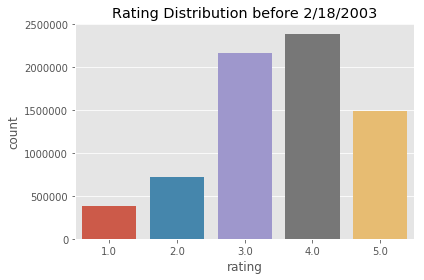

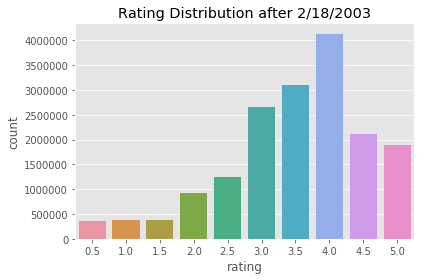

In [25]:
sns.countplot(x='rating', data=ratingfilter[ratingfilter['timestamp']<first_half_star])
plt.title('Rating Distribution before 2/18/2003')
plt.tight_layout()
plt.show()
sns.countplot(x='rating', data=ratingfilter[ratingfilter['timestamp']>=first_half_star])
plt.title('Rating Distribution after 2/18/2003')
plt.tight_layout()
plt.show()

Overall, both distribution is similar, they are both left-skewed, with 3 and 4 stars being most prominent. 

**3a. How many ratings were submitted per year?**

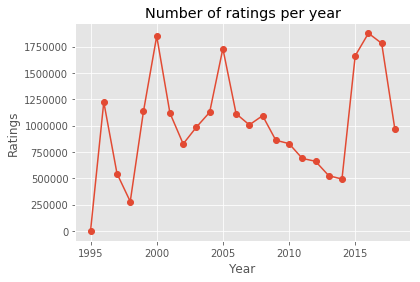

In [28]:
year_count = ratingfilter['year'].value_counts().sort_index()
plt.plot(year_count.index, year_count, 'o-')
plt.xlabel('Year')
plt.ylabel('Ratings')
plt.title('Number of ratings per year')
plt.show()

**3b. How many ratings were submitted per month?**


In [29]:
month_count = ratingfilter[['year', 'month', 'rating']].groupby(['year', 'month']).count()
month_count = month_count.rename(index = str, columns = {'rating': 'number of ratings'})
month_count = month_count.reset_index()
month_count['date'] = month_count[['year', 'month']].apply(
    lambda x: datetime(year = int(x[0]), month = int(x[1]), day = 1), axis = 1)
month_count = month_count.set_index('date', drop = True)
month_count.head(5)

,year,month,number of ratings
date,,,
1995-01-01,1995,1,4
1996-01-01,1996,1,42
1996-02-01,1996,2,868
1996-03-01,1996,3,5034
1996-04-01,1996,4,31192


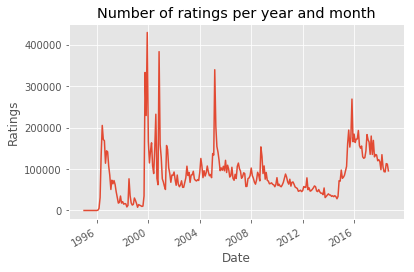

In [30]:
month_count['number of ratings'].plot()
plt.xlabel('Date')
plt.ylabel('Ratings')
plt.title('Number of ratings per year and month')
plt.show()

Number of ratings has not been consistent over the years. There were large changes from 1996 to 2005, and then a gradual decrease after until around early 2015, then ratings started increase again after 2015.

So, number of ratings given has not been consistent over the years, what about the average ratings?

**4. How consistent are the average ratings over the years?**

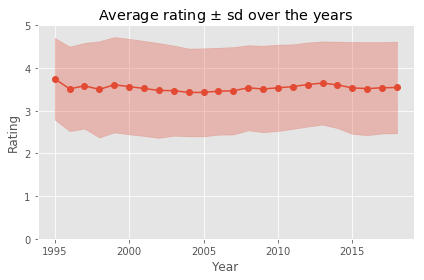

In [31]:
average_rating_year = ratingfilter.groupby('year')['rating'].agg(['mean', 'std']).reset_index()
year, mean, sd = average_rating_year['year'], average_rating_year['mean'], average_rating_year['std']
l, = plt.plot(year, mean, 'o-', label='Mean Rating')
plt.fill_between(year, mean-sd, mean+sd, alpha=0.3, color=l.get_color())
plt.ylim([0, 5])
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title(r'Average rating $\pm$ sd over the years')
plt.tight_layout()
plt.show()

Average ratings over the years are fairly consistent, around 3.5.

Lastly, I want to see which genre received the highest number of ratings.

In [32]:
moviegenre = pd.DataFrame(movies.genres.str.split('|').tolist()).stack()
moviegenre.value_counts()

Drama                 24144
Comedy                15956
Thriller               8216
Romance                7412
Action                 7130
Horror                 5555
Documentary            5118
Crime                  5105
(no genres listed)     4266
Adventure              4067
Sci-Fi                 3444
Mystery                2773
Children               2749
Animation              2663
Fantasy                2637
War                    1820
Western                1378
Musical                1113
Film-Noir               364
IMAX                    197
dtype: int64

In [33]:
df = pd.merge(ratingfilter, movies, on = 'movieId')
df.head()

,userId,movieId,rating,timestamp,year,month,day,title,genres
0,56769,1176,4.0,1995-01-09 03:46:44,1995,1,9,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
1,51073,1176,1.0,1996-10-23 02:01:56,1996,10,23,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
2,281674,1176,3.0,1996-10-23 05:56:28,1996,10,23,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
3,273749,1176,2.0,1996-10-26 00:09:34,1996,10,26,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
4,282742,1176,4.0,1996-10-26 03:53:55,1996,10,26,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance


In [34]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Planet Earth II (2016)                     4.494681
Planet Earth (2006)                        4.455123
Shawshank Redemption, The (1994)           4.408164
Band of Brothers (2001)                    4.398528
The Godfather Trilogy: 1972-1990 (1992)    4.353012
Name: rating, dtype: float64

In [35]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 70865
Pulp Fiction (1994)                 68787
Shawshank Redemption, The (1994)    66586
Silence of the Lambs, The (1991)    64403
Matrix, The (1999)                  64378
Name: rating, dtype: int64

In [36]:
avgrating = pd.DataFrame(df.groupby('title')['rating'].mean())

# add number of rating for a movie to rating_mean_count dataframe
avgrating['rating_counts'] = pd.DataFrame(df.groupby('title')['rating'].count())
avgrating.head()

,rating,rating_counts
title,,
"""Great Performances"" Cats (1998)",2.920000,125
$5 a Day (2008),2.775862,29
$9.99 (2008),3.017857,56
'71 (2014),3.708333,312
'Hellboy': The Seeds of Creation (2004),3.089744,78


In [37]:
avgrating = avgrating.sort_values(['rating_counts', 'rating'], ascending=False)
avgrating.head(10)

,rating,rating_counts
title,,
Forrest Gump (1994),4.016510,70865
Pulp Fiction (1994),4.197864,68787
"Shawshank Redemption, The (1994)",4.408164,66586
"Silence of the Lambs, The (1991)",4.143891,64403
"Matrix, The (1999)",4.150416,64378
Star Wars: Episode IV - A New Hope (1977),4.127666,60811
Jurassic Park (1993),3.661799,58826
Star Wars: Episode V - The Empire Strikes Back (1980),4.153716,54064
Braveheart (1995),3.974623,53867


Movies with higher number of rating usually have high average rating as well since a good movie is normally well-known and a well-known movie is watched by large number of people, let's see if this is also the case for this dataset. 

Let's plot average rating against number of ratings.

/Users/meiyanghuang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


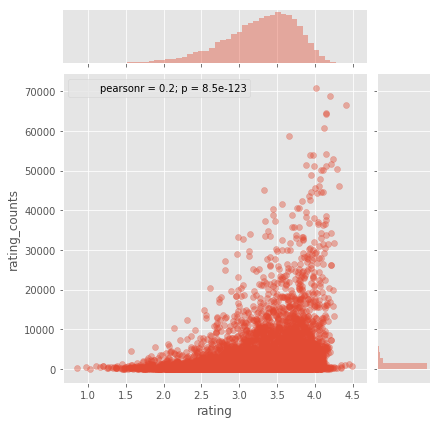

In [38]:
sns.jointplot(x= 'rating', y='rating_counts', data= avgrating, alpha=0.4)

In [39]:
from scipy.stats.stats import pearsonr
pearsonr(avgrating['rating'], avgrating['rating_counts'])

(0.20182623954174536, 8.548675041901814e-123)

In [40]:
np.corrcoef(avgrating['rating'], avgrating['rating_counts'])[0,1]

0.20182623954174553

The plot shows that movies with higher average rating actually have more number of ratings, compare with movies that have lower average ratings.

Let's now find similarity between movies.

I will use correlation between ratings of a movie as similarity metric. To find the correlation between rating of a movie, let's create a matrix where each column is a movie name and each row contains the rating assigned by a specific user to that movie. 

In [ ]:
user_movie_rating = df.pivot_table(index = 'userId',
                                  columns = 'movieId',
                                  values = 'rating').fillna(0)
user_movie_rating.head()

Each column contains all the user rating for a particular movie. Let's find all the user rating for the movie 'Pulp Fiction' and find movies similar to it. 

In [48]:
pulp_fiction_rating = user_movie_rating['Pulp Fiction (1994)']
pulp_fiction_rating.head()

userId
4     5.0
5     5.0
10    NaN
14    4.0
15    5.0
Name: Pulp Fiction (1994), dtype: float64

Let's retrieve all movies that are similar to 'Pulp Fiction (1994).

In [49]:
movies_like_pf = user_movie_rating.corrwith(pulp_fiction_rating)

corr_pf = pd.DataFrame(movies_like_pf, columns = ['Correlation'])
corr_pf.dropna(inplace=True)
corr_pf.head()

,Correlation
title,
"""Great Performances"" Cats (1998)",0.200654
$5 a Day (2008),0.394174
$9.99 (2008),0.388384
'71 (2014),0.221580
'Hellboy': The Seeds of Creation (2004),0.109314


In [50]:
corr_pf.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
Pulp Fiction (1994),1.000000
Tanu Weds Manu (2011),0.730543
Eighth Grade (2018),0.691153
Doodlebug (1997),0.649161
Eddie Izzard: Circle (2002),0.610451
"Mystery of the Third Planet, The (Tayna tretey planety) (1981)",0.606059
"Thieves, The (Dodookdeul) (2012)",0.603123
Winter in Prostokvashino (1984),0.595125
Karlson Returns (1970),0.594863


In [51]:
corr_pf = corr_pf.join(rating_mean_count['rating_counts'])
corr_pf.head()

,Correlation,rating_counts
title,,
"""Great Performances"" Cats (1998)",0.200654,125
$5 a Day (2008),0.394174,29
$9.99 (2008),0.388384,56
'71 (2014),0.221580,312
'Hellboy': The Seeds of Creation (2004),0.109314,78


In [52]:
corr_pf[corr_pf['rating_counts']>50].sort_values('Correlation', ascending=False).head()

,Correlation,rating_counts
title,,
Pulp Fiction (1994),1.000000,68787
Tanu Weds Manu (2011),0.730543,51
Eighth Grade (2018),0.691153,55
Doodlebug (1997),0.649161,94
Eddie Izzard: Circle (2002),0.610451,54


In [56]:
user_movie_rating.head()

title,"""Great Performances"" Cats (1998)",$5 a Day (2008),$9.99 (2008),'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),...,[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),iBoy (2017),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: Return of Xander Cage (2017),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.5,NaN,NaN,3.5,NaN,NaN,3.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
